<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº10
#### Mathilde d'Hébrail





Utilice las siguientes metodologías no lineales de estimación-substracción para la remoción de la interferencia de línea de base, y compare con las técnicas lineales del punto anterior en las mismas regiones. Luego discuta las ventajas y desventajas de cada técnica.

In [15]:
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
#from pytc2.sistemas_lineales import plot_plantilla

fig_sz_x = 14
fig_sz_y = 5
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

def vertical_flaten(a):

    return a.reshape(a.shape[0], 1)

## Filtrado de mediana

Estimación del movimiento de línea de base a partir del filtrado de mediana. A partir de la siguiente estimación del movimiento de línea de base

                                                b^=med600{med200{s}}  
                                    
Donde 
- s representa la señal de ECG a partir de la que estimamos el movimiento de la línea de base b^
- El operador med200 calcula muestra a muestra la mediana en los 200 ms previos a la muestra actual. Luego dicha estimación la substraemos para estimar la actividad eléctrica cardíaca x^

                                                     x^=s−b^

#### Cargar el señal

[('ecg_lead', (1129116, 1), 'double'), ('qrs_pattern1', (113, 1), 'double'), ('heartbeat_pattern1', (411, 1), 'double'), ('heartbeat_pattern2', (441, 1), 'double'), ('qrs_detections', (1903, 1), 'double')]


Text(0.5, 1.0, 'Heartbeat patern 2')

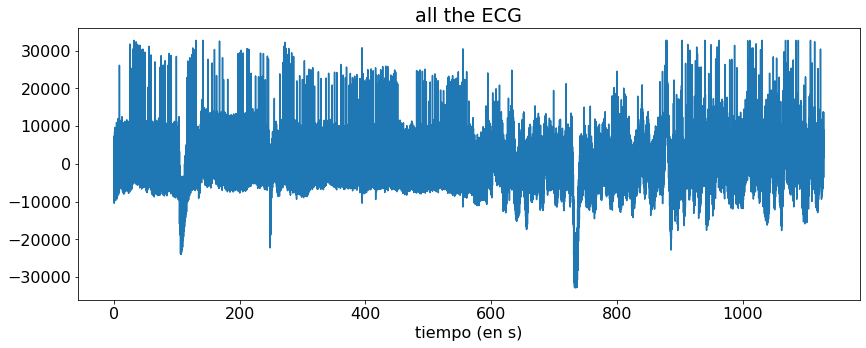

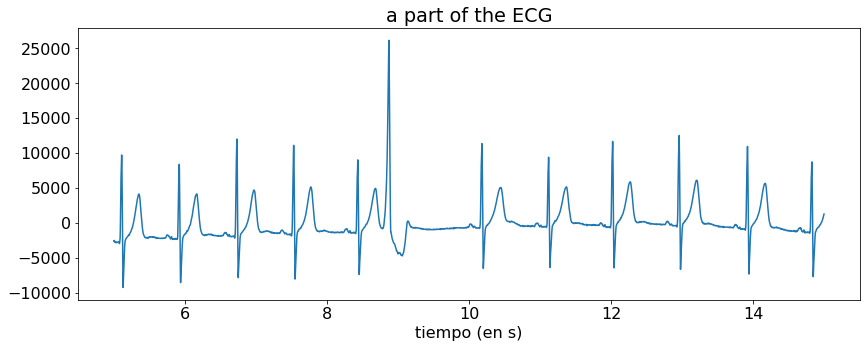

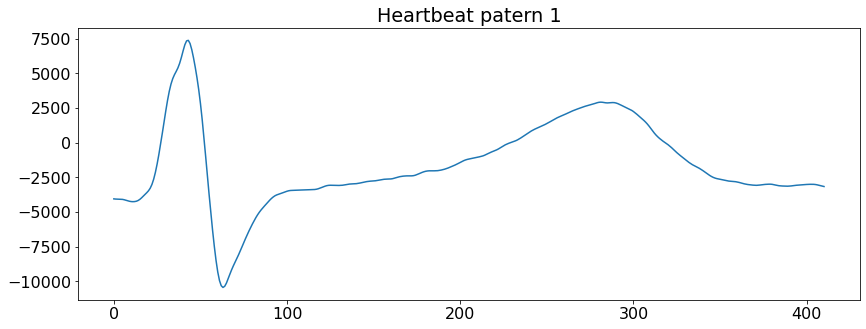

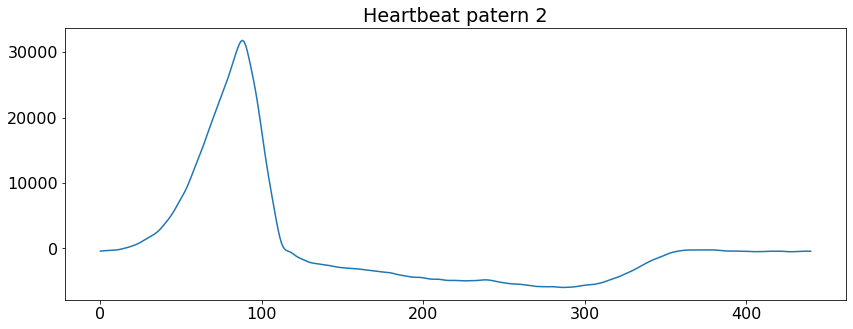

In [16]:
mat_struct = sio.loadmat('ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten().astype(float)
cant_muestras = len(ecg_one_lead)

fs_ecg = 1000 # Hz
nyq_frec = fs_ecg / 2

# para listar las variables que hay en el archivo
print(sio.whosmat('ECG_TP4.mat'))

tt = np.arange(0, len(ecg_one_lead)/fs_ecg, 1/fs_ecg).flatten()

hb_1 = vertical_flaten(mat_struct['heartbeat_pattern1'])
hb_2 = vertical_flaten(mat_struct['heartbeat_pattern2'])

plt.figure(1)
plt.plot(tt, ecg_one_lead)
plt.xlabel("tiempo (en s)")
plt.title("all the ECG")

plt.figure(2)
plt.plot(tt[5000:15000], ecg_one_lead[5000:15000])
plt.xlabel("tiempo (en s)")
plt.title("a part of the ECG")

plt.figure(3)
plt.plot(hb_1)
plt.title("Heartbeat patern 1")

plt.figure(4)
plt.plot(hb_2)
plt.title("Heartbeat patern 2")

#### Applicacion del filter

In [17]:
ecg_short =ecg_one_lead[720000:750000]

In [18]:
# Étape 1 : Médiane sur 200
baseline_200 = sig.medfilt(ecg_short, kernel_size=201)

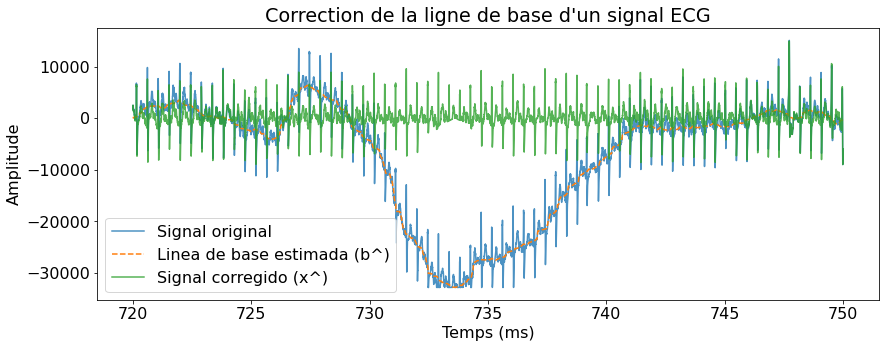

In [19]:
# Étape 2 : Médiane sur 600
baseline_600 = sig.medfilt(baseline_200, kernel_size=601)

# Signal corrigé
corrected_signal = ecg_short - baseline_600

# Visualisation
plt.figure()
plt.plot(tt[720000:750000], ecg_short, label="Signal original", alpha=0.8)
plt.plot(tt[720000:750000], baseline_600, label="Linea de base estimada (b^)", linestyle="--")
plt.plot(tt[720000:750000], corrected_signal, label="Signal corregido (x^)", alpha=0.8)
plt.legend()
plt.title("Correction de la ligne de base d'un signal ECG")
plt.xlabel("Temps (ms)")
plt.ylabel("Amplitude")
plt.show()

Esta tecnica nececita menos codigo que armar un filtro butterworth o algo asi. Funciona muy bien, y no podemos tener contaminacion de baja o alta frecuencia. Pero puede consumir mucho tiempo y por eso lo pude hacer solamente con una pequeña parte del señal.

## Segmentos isoelectricos

 Estimación del movimiento de línea de base a partir de los segmentos isoeléctricos de cada latido. A partir de las detecciones provistas, puede estimar aproximadamente el nivel isoeléctrico, es decir el momento donde la actividad eléctrica cardíaca es nula. El intervalo entre la onda P y Q, es un buen momento para estimar las características de las señales interferentes que originan el movimiento de la línea de base.  
 Vimos en la TS9 que el punto isoelectrico es aproximadamente a 200ms mas quelos puntos de qrs_detections.

In [20]:
cut_points = mat_struct['qrs_detections']

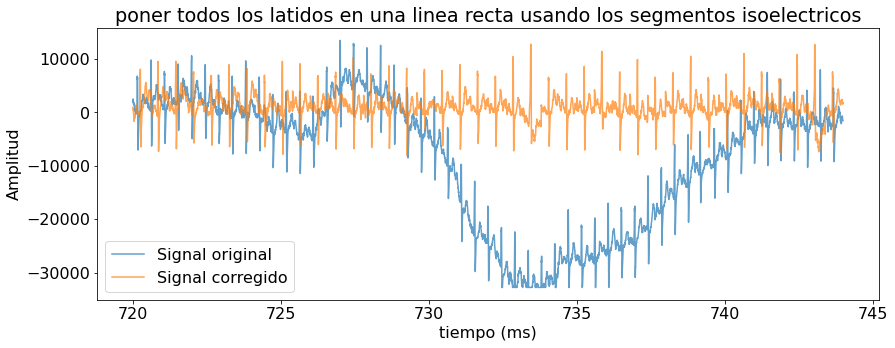

In [21]:
array = []

for i in range(len(cut_points) - 1):
    segment_start = int(cut_points[i]-250)
    segment_end = int(cut_points[i]+350)
    segment_signal = ecg_one_lead[segment_start:segment_end]
    segment_signal = segment_signal - segment_signal[200]
    #segment_signal = normalize(segment_signal)
    array.extend(segment_signal)
    
    
    
    
    
plt.figure()
plt.plot(tt[720000:744000], ecg_one_lead[720000:744000], label="Signal original", alpha=0.7)
plt.plot(tt[720000:744000], array[720000:744000], label="Signal corregido", alpha=0.7)
plt.title('poner todos los latidos en una linea recta usando los segmentos isoelectricos')
plt.xlabel("tiempo (ms)")
plt.ylabel("Amplitud")
plt.legend()
plt.show()

Esta tecnica es mas rapida que hacer el filtrado de mediana, pero tenemos que conocer la señal y saber exactamente donde estan los segmentos isoelectricos. Ademas, puede haber pequeñas variaciones porque los segmentos no son todo el tiempo exactamente en el mismo lugar o exactamente isoelectrico.